In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/EEGdataStreamingAlphaWaves.csv", sep=",")
end = 750
fs = 250
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data
df

,Time,FZ,C3,CZ,C4,PZ,PO7,OZ
0,208369.953125,335476.81250,377657.68750,290173.03125,683538.7500,220495.328125,210410.921875,217626.515625
1,208087.859375,335087.18750,376858.75000,289806.90625,682947.0625,220386.687500,210169.890625,217256.640625
2,207808.921875,334279.28125,375964.21875,289545.68750,682030.6250,220295.312500,209929.828125,216953.015625
3,207905.296875,334132.75000,376160.12500,289733.34375,682073.6875,220342.968750,210009.937500,217120.203125
4,208253.531250,334863.93750,377178.56250,290115.28125,682997.1875,220460.906250,210300.515625,217529.687500
...,...,...,...,...,...,...,...,...
745,208227.156250,334289.21875,372043.37500,289840.09375,682726.0000,220439.984375,210266.718750,217478.375000
746,208406.250000,334982.31250,372651.68750,289965.53125,683437.0625,220487.453125,210420.046875,217642.171875
747,208162.515625,334738.31250,372000.18750,289635.53125,682979.5625,220385.625000,210213.875000,217311.359375
748,207853.890625,333931.40625,371025.65625,289325.09375,682025.0000,220286.203125,209952.718750,216961.062500


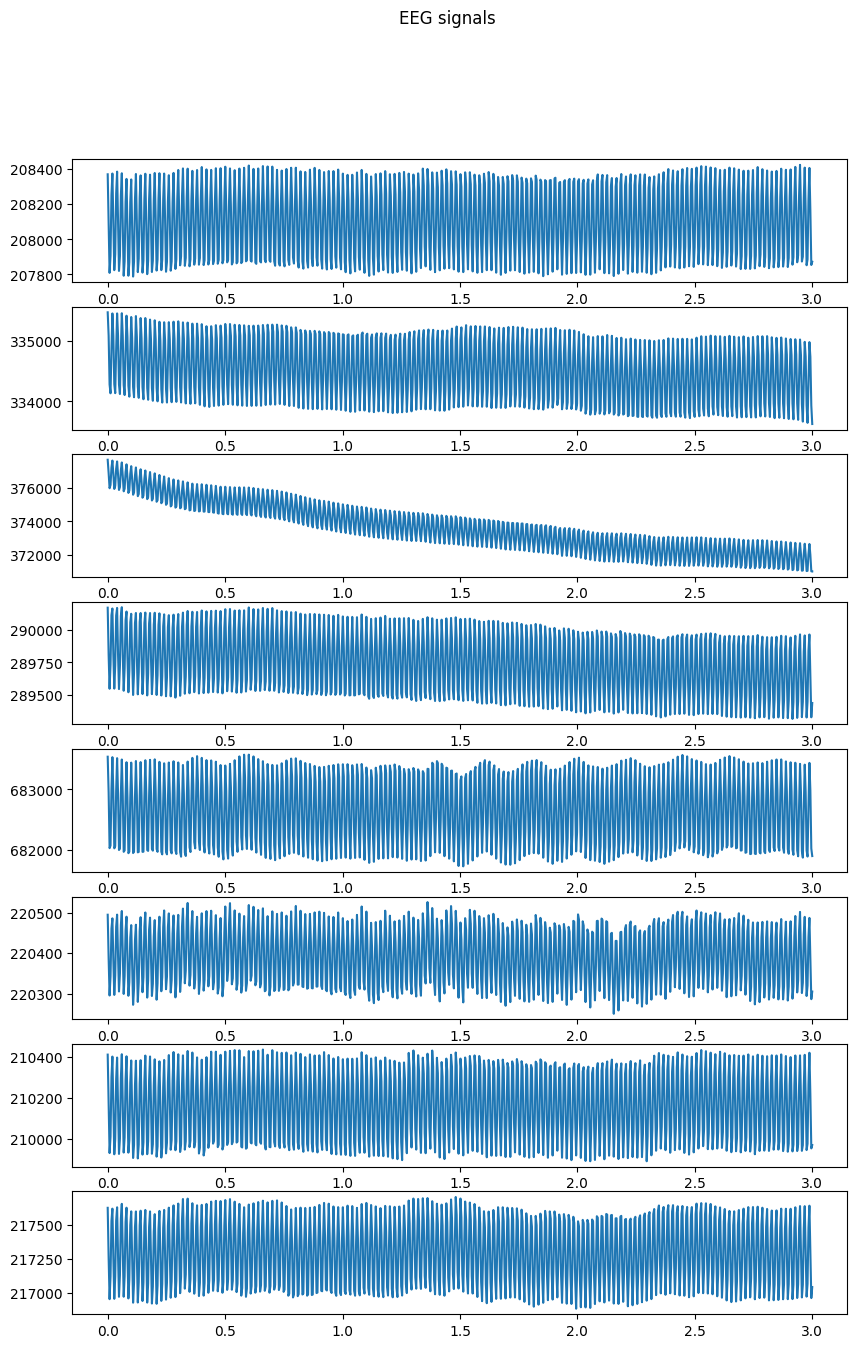

In [7]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df.iloc[:,i])


In [11]:
from scipy.signal import butter, lfilter, lfilter_zi
# Define the filter parameters
lowcut = 2
highcut = 30
fs = 250  # Sampling frequency
# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')
# Apply the filter to each column of the DataFrame
zi = lfilter_zi(b, a)
y = lfilter(b, a, df)


In [47]:
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal

# Define the filter parameters
lowcut = 4
highcut = 20
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to each column of the DataFrame
zi = lfilter_zi(b, a) * df.iloc[0, 0]
df_filt = lfilter(b, a, df)

# import scipy.signal as signal

# Define the notch filter parameters
fs = 250  # Sampling frequency
f0 = 50  # Notch frequency
Q = 30  # Quality factor

# Design the notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Apply the filter to each column of the DataFrame
df_filt1 = lfilter(b, a, df_filt)



In [48]:
# Remove the DC component
df_filt1 = signal.detrend(df_filt1, axis=0)

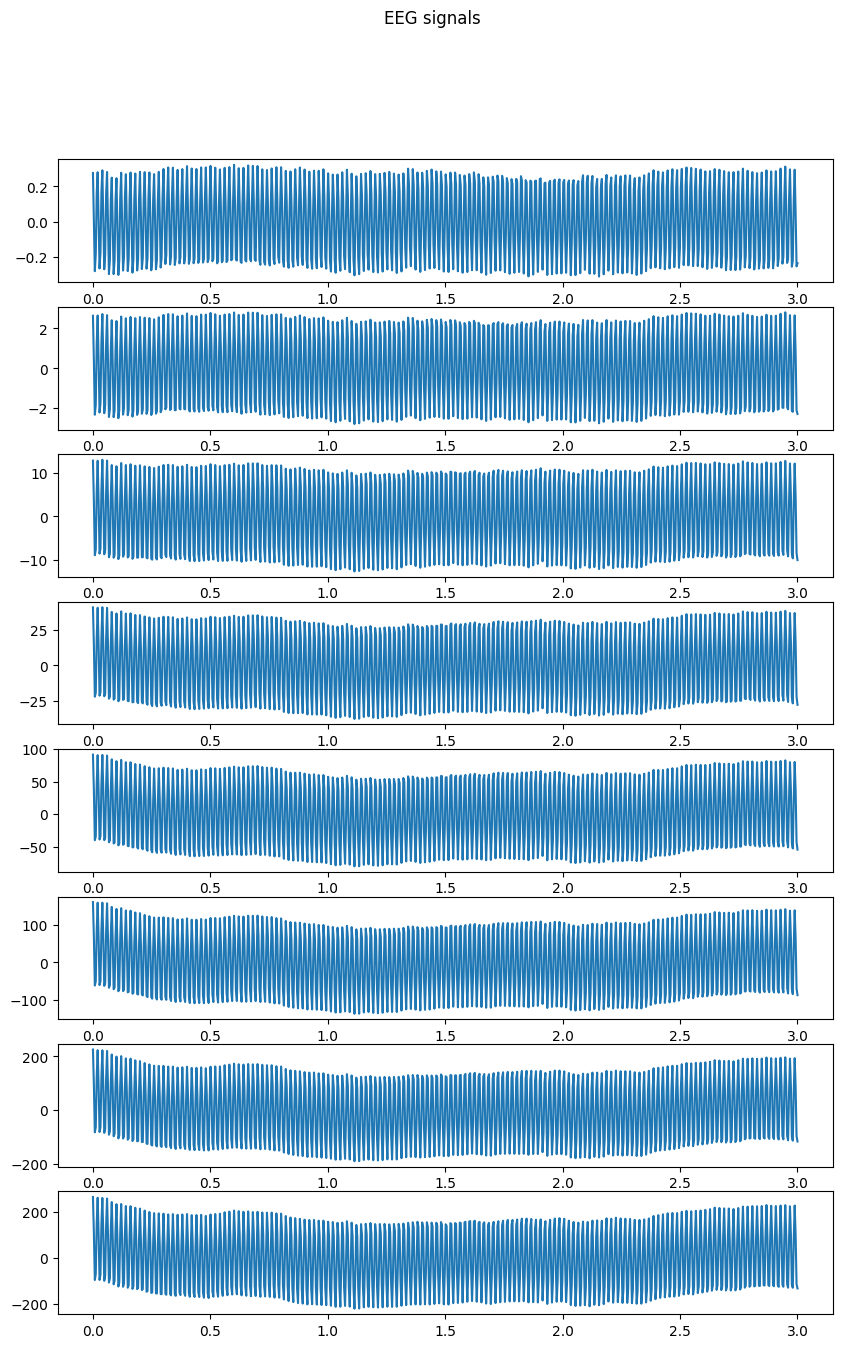

In [49]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df_filt1[:,i])

In [43]:
from scipy.fft import rfft, rfftfreq 
from scipy import signal
from scipy.fft import fftshift

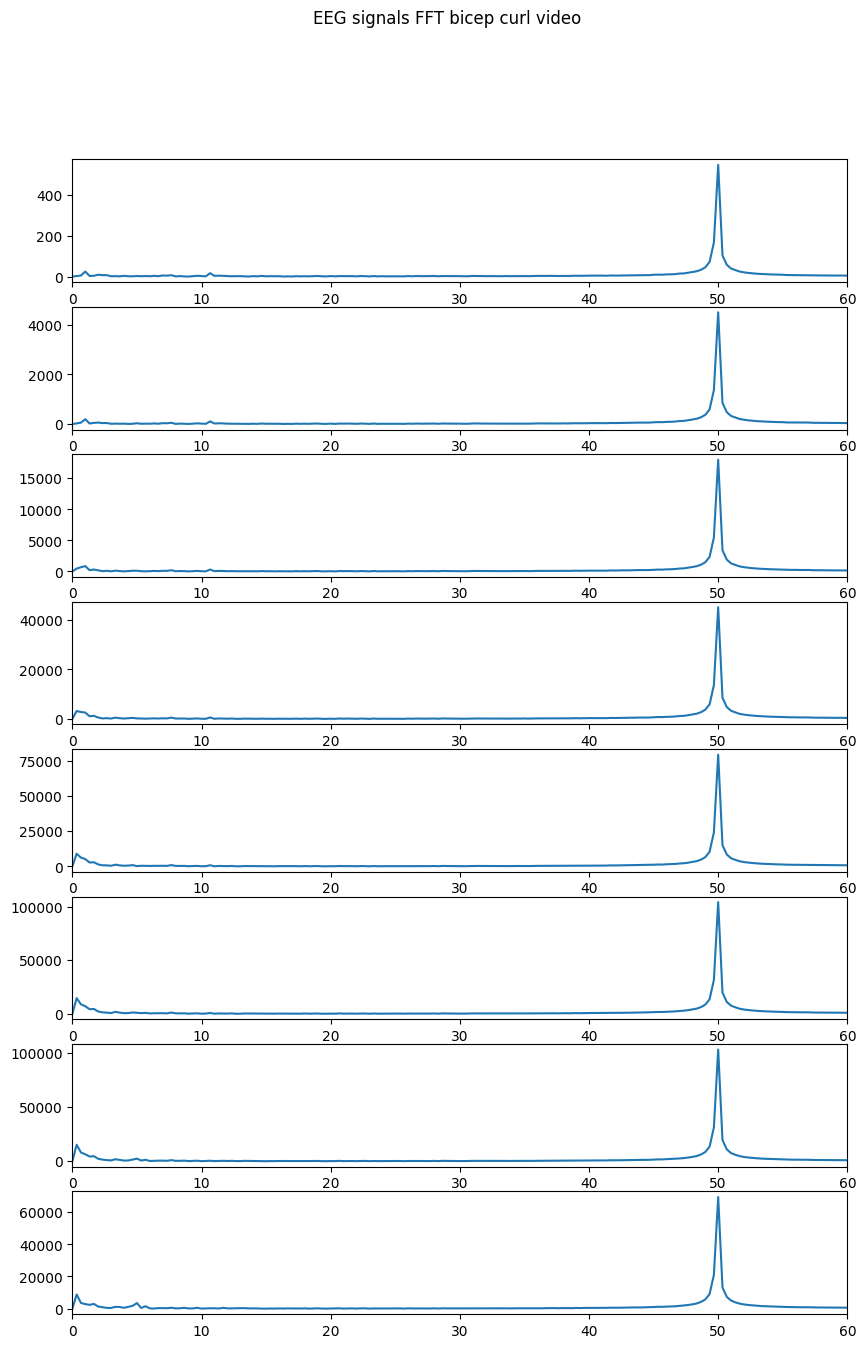

In [46]:
xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals FFT bicep curl video')
for i in range(8):
    yf = rfft(df_filt1[:,i])
    axs[i].plot(xf[:], np.abs(yf)[:])
    axs[i].set_xlim([0, 60])
    # Setting the number of ticks 
    axs[i].locator_params(axis='x', nbins=10)
    